In [ ]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import scipy.stats as ss
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from scipy.stats import norm

import keras
import tensorflow
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, LeakyReLU, Dropout
from keras import backend
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.utils import get_custom_objects
from keras import backend as K
from keras.activations import elu, sigmoid
import tensorflow as tf

In [ ]:
import tensorflow as tf
tf.keras.backend.set_floatx('float64')

In [ ]:
N = norm.cdf
def BS_CALL(S, K, T, r, q , sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S*(math.exp(-q*T))* N(d1) - K * np.exp(-r*T)* N(d2)

In [ ]:
price = np.random.uniform(10, 20, 300000)
strike = np.random.uniform(10, 20, 300000)
time = np.random.uniform(0.1, 3, 300000)
intrest = np.random.uniform(0.01, 0.03, 300000)
divident = np.random.uniform(0, 0.03, 300000)
volatility = np.random.uniform(0.05, 0.3, 300000)
call = np.zeros(300000)

In [ ]:
for i in range(0,300000):
  call[i] = BS_CALL(price[i],strike[i],time[i],intrest[i],divident[i],volatility[i])

In [ ]:
df = pd.DataFrame()

In [ ]:
df['Stock'] = price.tolist()
df['Strike'] = strike.tolist()
df['Time'] = time.tolist()
df['Intrest'] = intrest.tolist()
df['Divident'] = divident.tolist()
df['Volatility'] = volatility.tolist()
df['Call'] = call.tolist()

In [ ]:
df_filtered = df[df['Call'] <= 10]
df_filtered = df_filtered[df_filtered['Call'] >= 0.001]

In [ ]:
df_filtered['Stock'] = df_filtered['Stock'].div(df_filtered.Strike)
df_filtered['Call'] = df_filtered['Call'].div(df_filtered.Strike)
MinCall = df_filtered.loc[df_filtered["Call"].idxmin()].Call
df_filtered['Strike'] = 1
Strike = df_filtered.Strike.values
df_filtered = df_filtered.drop('Strike', axis=1)

In [ ]:
df_filtered['Call'] = df_filtered['Call'] - 0.5

In [ ]:
prices = df_filtered.values

In [ ]:
X = prices[:,:5]
y = prices[:,5:6]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def custom_activation(x):
    return (K.softplus(x)-0.5)

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

In [ ]:
def MELU(z):
  cond = K.greater(z, 0)
  return K.switch(cond, (((0.5*(K.pow((z),2)))+(0.02*(z)))/((z)+0.040816326)),0.49*(K.exp(z)-1))

get_custom_objects().update({'MELU': Activation(MELU)})

In [ ]:
from pandas.core.arrays.arrow.array import Any
nodes = 128

# Create Model
model = Sequential()

# Layer 1
model.add(Dense(nodes , input_shape=(5,)))
model.add(Activation(LeakyReLU(1.0)))

# Layer 2
model.add(Dense(nodes))
model.add(Activation (MELU))

# Layer 3
model.add(Dense(nodes))
model.add(Activation (MELU))

# Layer 4 - Output Layer
model.add(Dense(1))
model.add(Activation(custom_activation))

In [ ]:
model.compile(loss= 'MSE',
  optimizer='adam',)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               768       
                                                                 
 activation_2 (Activation)   (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 activation_3 (Activation)   (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 activation_4 (Activation)   (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

In [ ]:
model.fit(X_train, y_train, epochs = 15, batch_size = 64)

Epoch 1/15
3444/3444 [==============================] - 25s 7ms/step - loss: 0.0029
Epoch 2/15
3444/3444 [==============================] - 25s 7ms/step - loss: 1.9331e-04
Epoch 3/15
3444/3444 [==============================] - 24s 7ms/step - loss: 8.7847e-05
Epoch 4/15
3444/3444 [==============================] - 22s 6ms/step - loss: 2.8599e-05
Epoch 5/15
3444/3444 [==============================] - 24s 7ms/step - loss: 1.5141e-05
Epoch 6/15
3444/3444 [==============================] - 23s 7ms/step - loss: 1.2473e-05
Epoch 7/15
3444/3444 [==============================] - 23s 7ms/step - loss: 9.6561e-06
Epoch 8/15
3444/3444 [==============================] - 23s 7ms/step - loss: 7.6790e-06
Epoch 9/15
3444/3444 [==============================] - 23s 7ms/step - loss: 6.5942e-06
Epoch 10/15
3444/3444 [==============================] - 24s 7ms/step - loss: 6.4738e-06
Epoch 11/15
3444/3444 [==============================] - 22s 6ms/step - loss: 6.7036e-06
Epoch 12/15
3444/3444 [===========

In [ ]:
predictions = model.predict(X_test)

1722/1722 [==============================] - 6s 3ms/step


In [ ]:
predictions

array([[-0.32924872],
       [-0.42391904],
       [-0.47697427],
       ...,
       [-0.43105653],
       [-0.22378283],
       [-0.27807423]])

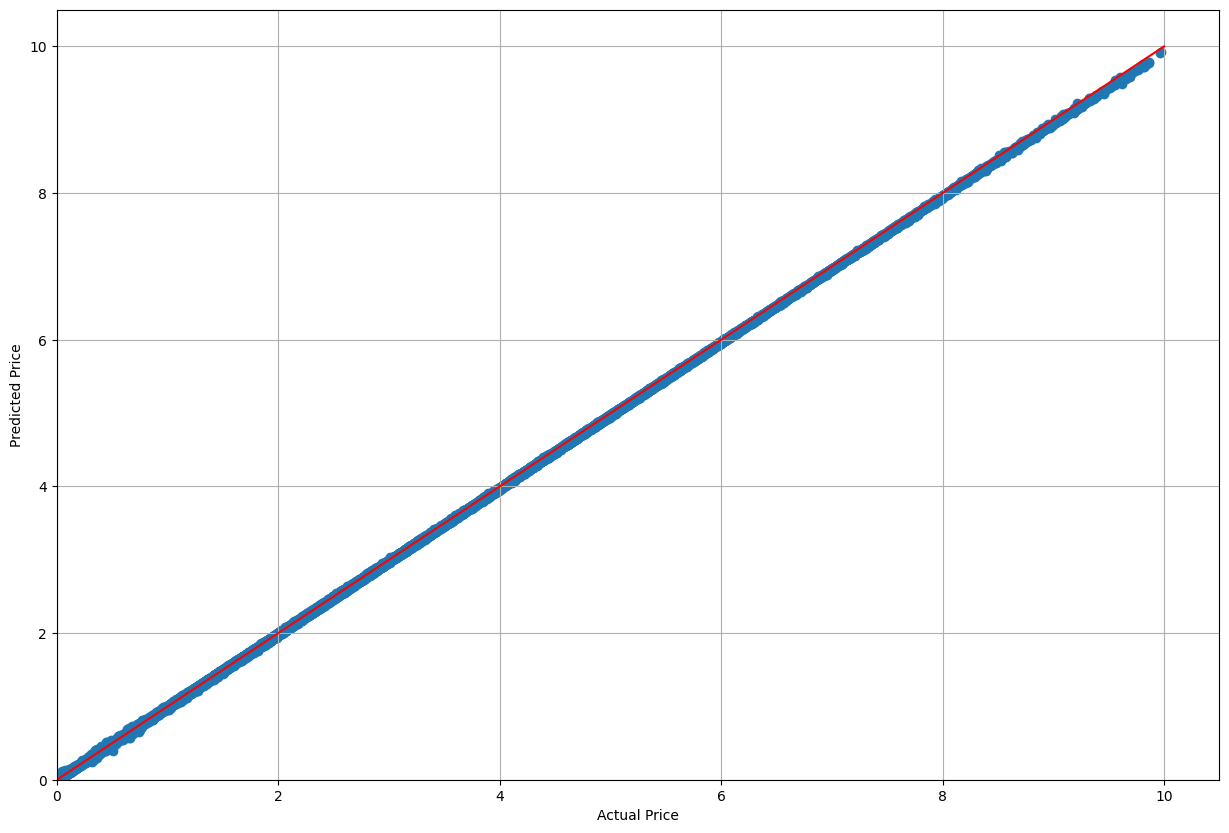

In [ ]:
plt.figure(figsize = (15,10))
plt.scatter((y_test+0.5)*10, (predictions+0.5)*10)
plt.axis((0, 10.5, 0, 10.5))
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.plot([0,10], [0,10], 'r')
plt.grid(True)

In [ ]:
InSamplePredictions = model.predict(X_train)

6887/6887 [==============================] - 20s 3ms/step


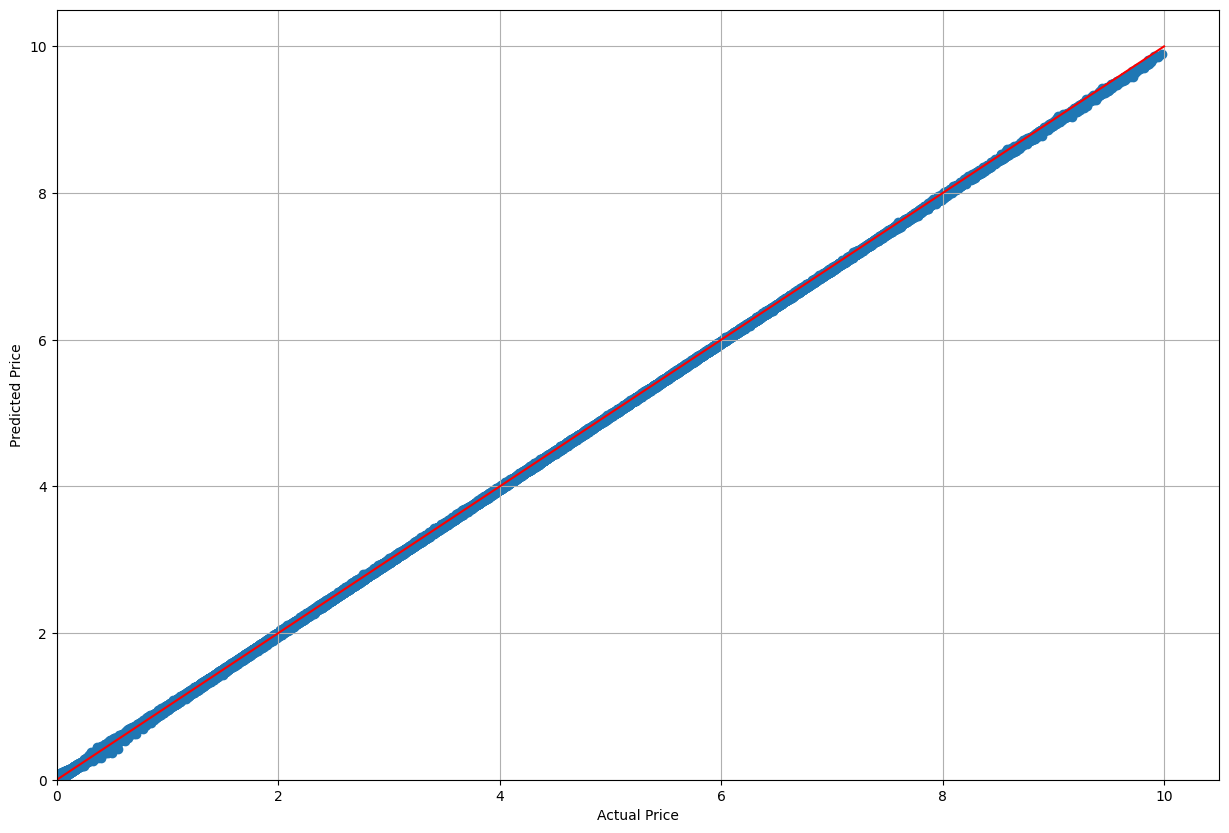

In [ ]:
#in sample (80)
plt.figure(figsize = (15,10))
plt.scatter((y_train+0.5)*10, (InSamplePredictions+0.5)*10)
plt.axis((0, 10.5, 0, 10.5))
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.plot([0,10], [0,10], 'r')
plt.grid(True)